# XIAO_ESP32S3_KWS_Sound_Classification
- TinyML - Edge Impulse Model Training analysis 
- M.Rovai @28May20213

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa
import librosa.display
import IPython.display

## Analizyng Audio raw sample

- From Edge Impulse Studio `Dashboard` - `Export Data` Option, download to your computer a zip file with the .wav raw data captured.
- Upload on /content one (or more) .wav samples
- Or upload one of the samples from the original dataset "Mini Speech Commands (Pete's dataset). 

In [2]:
!ls /content

0ab3b47d_nohash_0.wav		ei-xiao-esp32s3-kws-mfcc-y.npy
ei-xiao-esp32s3-kws-mfcc-X.npy	sample_data


In [3]:
sound_path = '/content/0ab3b47d_nohash_0.wav'

In [4]:
audio, sample_rate = librosa.load(sound_path, sr=16_000)
sample_rate

16000

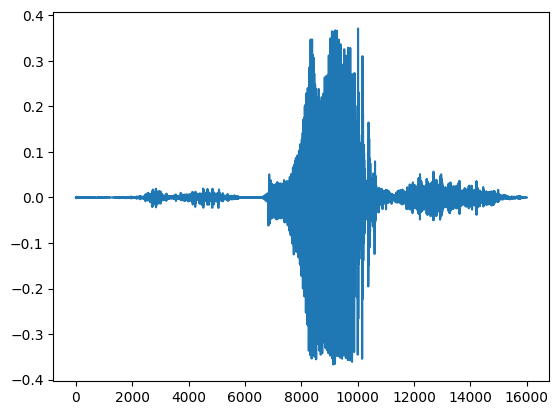

In [5]:
plt.plot(audio);

In [6]:
IPython.display.Audio(data=audio, rate=sample_rate)

In [7]:
 def fft(data, N=sample_rate, title = ''):  
    yf = scipy.fftpack.fft(data)
    plt.plot(2.0/N * np.abs(yf[:N//2]))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show();

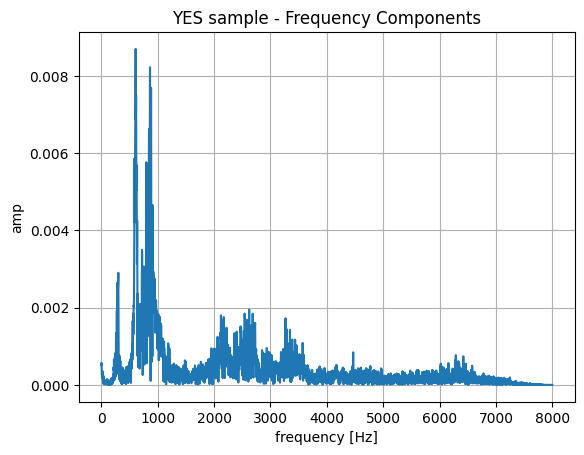

In [8]:
fft(audio, title = 'YES')

In [9]:
 def spectogram(data, NFFT=256, Fs=sample_rate, title=''):
    plt.specgram(data, NFFT, Fs)
    plt.xlabel('time (s)')
    plt.ylabel('frequency [Hz]')
    plt.title(title+' sample - Spectogram')
    plt.show();

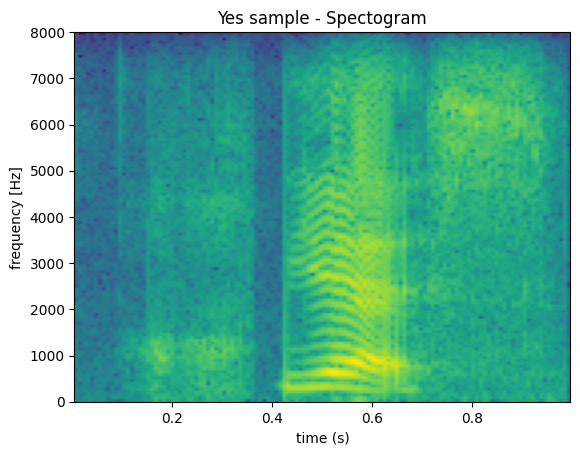

In [10]:
spectogram(audio, title='Yes')

## Analysing Edge Impulse Model Training


Download the training dataset (data and label) from the Studio Dashboard (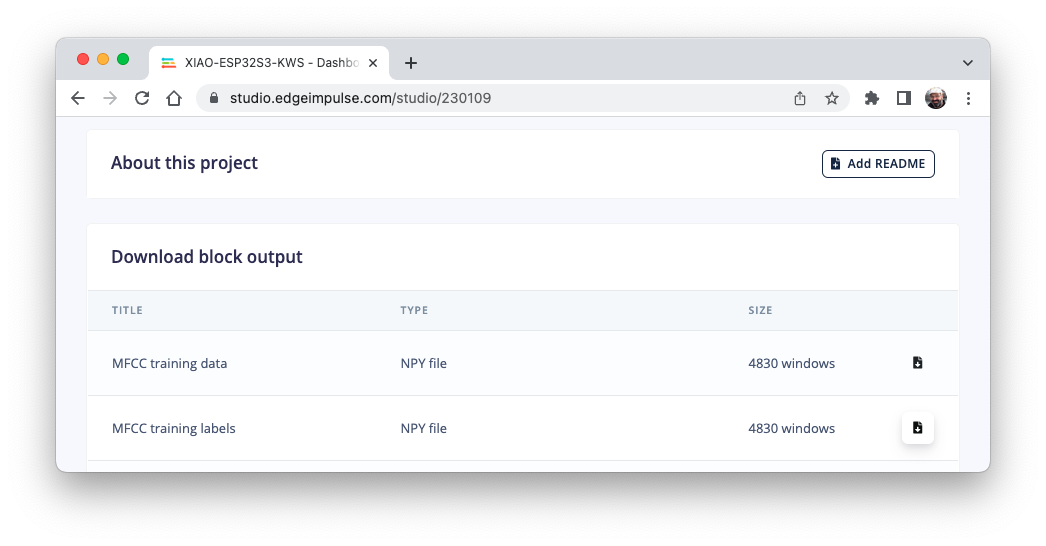

The Studio will provide here, data after extracting features through a processing block - so we can train a machine learning model.

Upload the data from your computer to Colab.

In [11]:
!ls 

0ab3b47d_nohash_0.wav		ei-xiao-esp32s3-kws-mfcc-y.npy
ei-xiao-esp32s3-kws-mfcc-X.npy	sample_data


In [12]:
X = np.load('ei-xiao-esp32s3-kws-mfcc-X.npy')
Y = np.load('ei-xiao-esp32s3-kws-mfcc-y.npy')[:,0]

In [13]:
X.shape, Y.shape

((4830, 637), (4830,))

In [14]:
image = X[3000]
img_length = image.shape[0]
img_length

637

In [15]:
columns = 13
rows = int(img_length / columns)
image = np.reshape(image, (rows, columns))
image.shape

(49, 13)

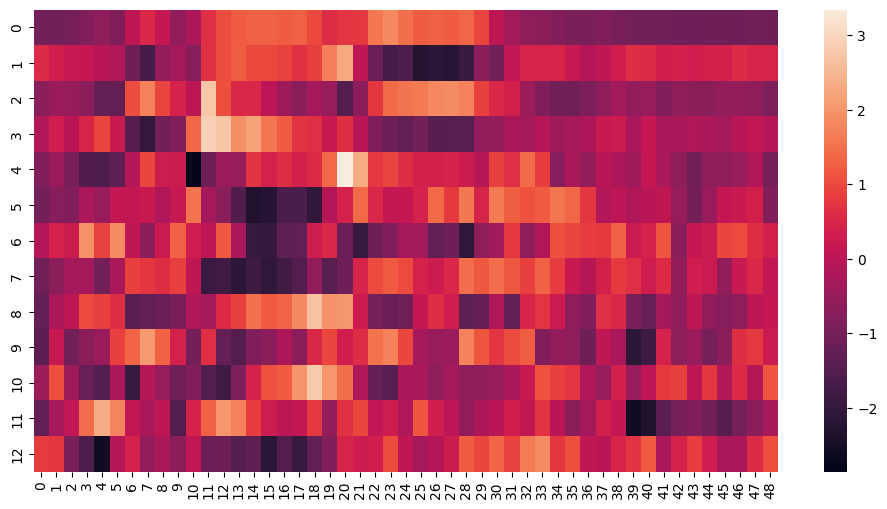

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(image.T);


In [17]:
label = Y[3000]
label

4

This sample is an YES ==> [ "no", "noise", "unknown", "yes" ]

Define our labels and split the data up in a test and training set:

In [18]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "no", "noise", "unknown", "yes" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [19]:
X_train.shape, input_length

((3864, 637), 637)

In [20]:
Y.shape

(4830, 4)

In [21]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3864, 637), (966, 637), (3864, 4), (966, 4))

In [22]:
def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=20)

callbacks = [early_stop]

Train the model:
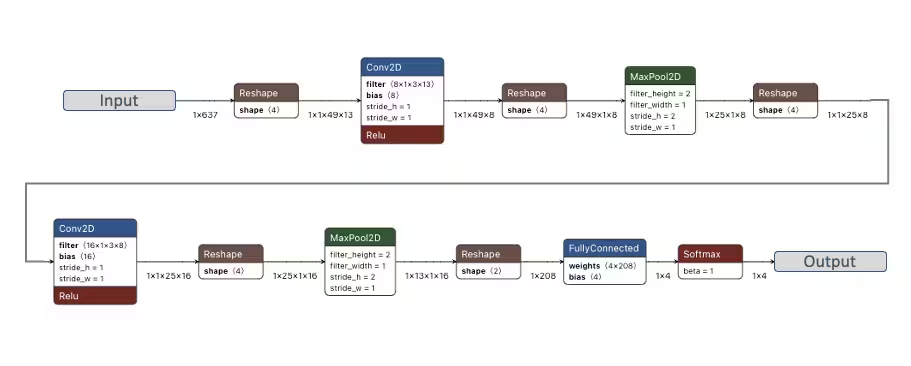

In [24]:
LEARNING_RATE = 0.005
BATCH_SIZE = 32
EPOCHS = 20

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, AveragePooling2D, BatchNormalization, TimeDistributed, Permute, ReLU, Softmax
from tensorflow.keras.optimizers import Adam
# Data augmentation for spectrograms, which can be configured in visual mode.
# To learn what these arguments mean, see the SpecAugment paper:
# https://arxiv.org/abs/1904.08779
# sa = SpecAugment(spectrogram_shape=[int(input_length / 13), 13], mF_num_freq_masks=0, F_freq_mask_max_consecutive=0, mT_num_time_masks=1, T_time_mask_max_consecutive=1, enable_time_warp=False, W_time_warp_max_distance=6, mask_with_mean=False)
# train_dataset = train_dataset.map(sa.mapper(), num_parallel_calls=tf.data.AUTOTUNE)

#train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
#validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

model.summary()

# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 49, 13)            0         
                                                                 
 conv1d (Conv1D)             (None, 49, 8)             320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 8)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            400       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 16)           0         
 1D)                                                    

In [26]:
for layer in model.layers:
    print(layer.output_shape)

(None, 49, 13)
(None, 49, 8)
(None, 25, 8)
(None, 25, 8)
(None, 25, 16)
(None, 13, 16)
(None, 13, 16)
(None, 208)
(None, 4)


In [27]:
# this controls the learning rate
opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [28]:
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)

for x, y in validation_dataset.take(1):
    print(x.shape, y.shape)

(32, 637) (32, 4)
(32, 637) (32, 4)


In [29]:
# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=2, callbacks=callbacks)


Epoch 1/20
121/121 - 2s - loss: 1.0964 - accuracy: 0.5380 - val_loss: 0.7586 - val_accuracy: 0.7298 - 2s/epoch - 15ms/step
Epoch 2/20
121/121 - 0s - loss: 0.6524 - accuracy: 0.7575 - val_loss: 0.5457 - val_accuracy: 0.8106 - 448ms/epoch - 4ms/step
Epoch 3/20
121/121 - 0s - loss: 0.5259 - accuracy: 0.8046 - val_loss: 0.4558 - val_accuracy: 0.8458 - 454ms/epoch - 4ms/step
Epoch 4/20
121/121 - 0s - loss: 0.4708 - accuracy: 0.8282 - val_loss: 0.4002 - val_accuracy: 0.8571 - 436ms/epoch - 4ms/step
Epoch 5/20
121/121 - 0s - loss: 0.4383 - accuracy: 0.8421 - val_loss: 0.3825 - val_accuracy: 0.8623 - 431ms/epoch - 4ms/step
Epoch 6/20
121/121 - 0s - loss: 0.4029 - accuracy: 0.8460 - val_loss: 0.3767 - val_accuracy: 0.8820 - 425ms/epoch - 4ms/step
Epoch 7/20
121/121 - 0s - loss: 0.3757 - accuracy: 0.8605 - val_loss: 0.3401 - val_accuracy: 0.8799 - 430ms/epoch - 4ms/step
Epoch 8/20
121/121 - 0s - loss: 0.3698 - accuracy: 0.8600 - val_loss: 0.3272 - val_accuracy: 0.8975 - 414ms/epoch - 3ms/step
Ep

In [30]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    if res == 'loss':
        plt.legend(['Training', res], loc='upper right')
    else:
        plt.legend(['Training', res], loc='lower right')
    plt.show() 


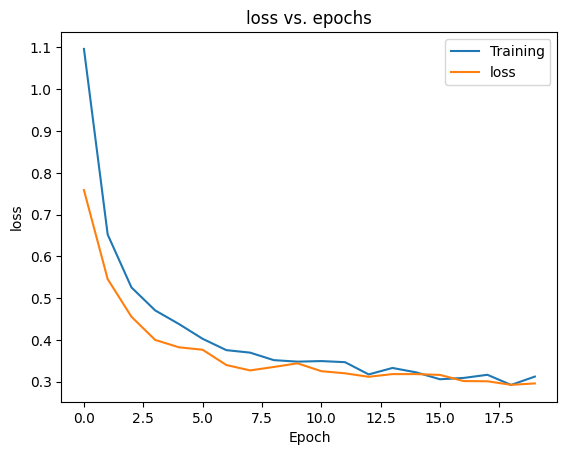

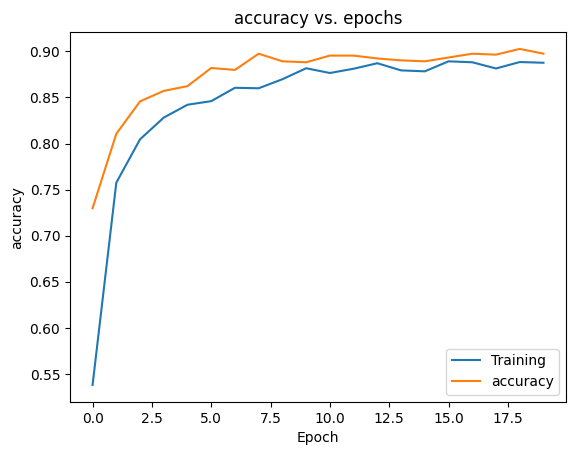

accuracy: 0.898


In [31]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')
get_test_accuracy(model, X_test, Y_test)

In [32]:
# Save the model to disk
model.save('cnn_v1_saved_model')

Convert and save TF model to a tflite model

In [33]:
# Convert TF model to a tflite model
from tensorflow.keras.models import load_model

model_cnn_v1 = load_model('cnn_v1_saved_model')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_size = open("cnn_v1.tflite","wb").write(tflite_model)
print("Quantized model (DEFAULT) is {:,} bytes".format(tflite_model_size))

Quantized model (DEFAULT) is 12,268 bytes
